#Importo Librerie

In [ ]:
import pandas as pd
import numpy as np
!pip install scikit-learn
!pip install surprise
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from surprise import SVD
from surprise import Dataset, Reader
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163006 sha256=26f128895f7f71d4665e4f769e666324f3745df7a70446aea42d33586b66957a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


#Carico csv e creazione dataFrame

Creo due dataFrame movies e ratings

In [ ]:
#Creo due dataFrame movies e ratings

movies = pd.read_csv(r'/content/movies.csv', sep=',', names=['movieId', 'title', 'genres'],  encoding="Latin1")
movies.drop(['genres'], axis=1, inplace=True)

# pd.read_csv: Utilizza la funzione read_csv della libreria pandas per leggere i dati da un file CSV.
# "movies.csv": Specifica il percorso del file CSV.
# sep=',': Specifica che il separatore tra le colonne nel file CSV è la virgola.
# names=['movieId', 'title', 'genres']: Assegna i nomi alle colonne del DataFrame.
# encoding="Latin1": Specifica l'encoding del file. Latin1 è comune per gestire caratteri speciali in testi in lingue europee.

ratings = pd.read_csv(r'/content/ratings.csv', sep=',', names =['userId', 'movieId', 'rating', 'timestamp'], encoding = "Latin1")
ratings.drop(['timestamp'], axis=1, inplace=True)

Visualizzo movies

In [ ]:
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [ ]:
# Aggiungi una nuova colonna binaria "binary_rating" basata sulla condizione specificata
ratings['binary_rating'] = ratings['rating'].apply(lambda x: 1 if x >= 3 else 0)

# Rimuovi la colonna "rating" se non è più necessaria
ratings = ratings.drop(columns=['rating'])

print(ratings)

        userId  movieId  binary_rating
0            1        1              1
1            1        3              1
2            1        6              1
3            1       47              1
4            1       50              1
...        ...      ...            ...
100831     610   166534              1
100832     610   168248              1
100833     610   168250              1
100834     610   168252              1
100835     610   170875              1

[100836 rows x 3 columns]


In [ ]:
import re

# Funzione per controllare se l'anno nel titolo è maggiore o uguale a 2015
def is_after_2015(title):
    match = re.search(r'\b(\d{4})\b', title)
    if match:
        year = int(match.group(1))
        return year >= 2015
    return False

    # Filtra il DataFrame per ottenere solo i titoli usciti dopo il 2015
filtered_movies = movies[movies['title'].apply(is_after_2015)]

In [ ]:
import pandas as pd
import random

# Estrai titoli casuali dal DataFrame filtrato
random_titles = random.sample(filtered_movies['title'].tolist(), 20)


# Stampare la lista di titoli casuali
print(random_titles)


['Kingsglaive: Final Fantasy XV (2016)', 'MystÃ¨re Ã\xa0 la Tour Eiffel (2015)', 'Indignation (2016)', 'Midnight Special (2015)', 'Visit, The (2015)', 'Imperium (2016)', "'Tis the Season for Love (2015)", 'Mystery Science Theater 3000: The Movie (1996)', 'Er ist wieder da (2015)', '7 Days in Hell (2015)', 'Sicario (2015)', 'Ghost in the Shell (2017)', 'Steve Jobs: The Man in the Machine (2015)', 'Betting on Zero (2016)', 'High Rise (2015)', 'Tomorrowland (2015)', 'Precious Cargo (2016)', 'The Danish Girl (2015)', "Don't Breathe (2016)", 'The Conjuring 2 (2016)']


In [ ]:
# Funzione per ottenere l'ID dato il titolo
def get_movie_id(title):
    return movies[movies['title'] == title]['movieId'].values[0]

    # Creare una lista di tuple (ID, titolo)
id_title_pairs = [(get_movie_id(title), title) for title in random_titles]

# Stampare la lista di ID e titoli casuali
for movie_id, title in id_title_pairs:
    print(f"MovieID: {movie_id}, Title: {title}")

MovieID: 161594, Title: Kingsglaive: Final Fantasy XV (2016)
MovieID: 171917, Title: MystÃ¨re Ã  la Tour Eiffel (2015)
MovieID: 160644, Title: Indignation (2016)
MovieID: 130576, Title: Midnight Special (2015)
MovieID: 140523, Title: Visit, The (2015)
MovieID: 162828, Title: Imperium (2016)
MovieID: 149380, Title: 'Tis the Season for Love (2015)
MovieID: 671, Title: Mystery Science Theater 3000: The Movie (1996)
MovieID: 143969, Title: Er ist wieder da (2015)
MovieID: 138204, Title: 7 Days in Hell (2015)
MovieID: 139644, Title: Sicario (2015)
MovieID: 168612, Title: Ghost in the Shell (2017)
MovieID: 141846, Title: Steve Jobs: The Man in the Machine (2015)
MovieID: 170907, Title: Betting on Zero (2016)
MovieID: 142420, Title: High Rise (2015)
MovieID: 132046, Title: Tomorrowland (2015)
MovieID: 157432, Title: Precious Cargo (2016)
MovieID: 141749, Title: The Danish Girl (2015)
MovieID: 161634, Title: Don't Breathe (2016)
MovieID: 159858, Title: The Conjuring 2 (2016)


In [ ]:
#Salvo le valutazioni:
#Utente 1-> id 611 (GIULIA)
#fight club, eternal sunshine, taxi driver, pretty woman, nothing hill
#no saw, si space jam, si iron man
valutazioni_user1 = {'userId': [611, 611, 611, 611, 611, 611, 611, 611],
                 'movieId': [2959, 7361, 111, 597, 2671, 148671, 673, 59315 ],
                 'binary_rating': [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]}

# Trova i titoli corrispondenti ai movieId forniti
movie_ids_input= [2959, 7361, 111, 597, 2671, 148671, 673, 59315 ]
titles_result = movies[movies['movieId'].isin(movie_ids_input)].set_index('movieId').loc[movie_ids_input]['title'].tolist()
# Stampa i titoli
print(f"Giulia ha valutato: {titles_result} ")

Giulia ha valutato: ['Fight Club (1999)', 'Eternal Sunshine of the Spotless Mind (2004)', 'Taxi Driver (1976)', 'Pretty Woman (1990)', 'Notting Hill (1999)', 'Saw (2003)', 'Space Jam (1996)', 'Iron Man (2008)'] 


In [ ]:
#Utente 2-> id 612 (GIACOMO)
#io sono leggenda, iron man 3, bad boys, coach carter, fast and furios
#? saw, si space jam, si iron man 1
valutazioni_user2 = {'userId': [612, 612, 612, 612, 612, 612, 612],
                 'movieId': [56174,102125, 145, 31225, 4369, 673, 59315],
                 'binary_rating': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

# Trova i titoli corrispondenti ai movieId forniti
movie_ids_input= [56174,102125, 145, 31225, 4369, 673, 59315]
titles_result = movies[movies['movieId'].isin(movie_ids_input)].set_index('movieId').loc[movie_ids_input]['title'].tolist()
# Stampa i titoli
print(f"Giacomo ha valutato: {titles_result} ")

Giacomo ha valutato: ['I Am Legend (2007)', 'Iron Man 3 (2013)', 'Bad Boys (1995)', 'Coach Carter (2005)', 'Fast and the Furious, The (2001)', 'Space Jam (1996)', 'Iron Man (2008)'] 


In [ ]:
#Utente 3-> id 613  (MATTEO)
#patch adams, forrest gump, il miglio verde, the prestige, sette anime
#? saw, si space jam, si iron man
valutazioni_user3 = {'userId': [613, 613, 613, 613, 613, 613, 613],
                 'movieId': [2431, 356, 54, 48780, 64716, 673, 59315],
                 'binary_rating': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
# Trova i titoli corrispondenti ai movieId forniti
movie_ids_input= [2431, 356, 54, 48780, 64716, 673, 59315]
titles_result = movies[movies['movieId'].isin(movie_ids_input)].set_index('movieId').loc[movie_ids_input]['title'].tolist()
# Stampa i titoli
print(f"Matteo ha valutato: {titles_result} ")

Matteo ha valutato: ['Patch Adams (1998)', 'Forrest Gump (1994)', 'Big Green, The (1995)', 'Prestige, The (2006)', 'Seven Pounds (2008)', 'Space Jam (1996)', 'Iron Man (2008)'] 


In [ ]:
#Utente 4-> id 614 (LORENZO)
#nuovo cinema paradiso, philadelhia, avatar, avengers, insospettabili sospetti
#si saw, si space jam, si iron man
valutazioni_user4 = {'userId': [614, 614, 614, 614, 614, 614, 614, 614],
                 'movieId': [1172, 508, 72998, 122912, 7414, 148671, 673, 59315],
                 'binary_rating': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
# Trova i titoli corrispondenti ai movieId forniti
movie_ids_input= [1172, 508, 72998, 122912, 7414, 148671, 673, 59315]
titles_result = movies[movies['movieId'].isin(movie_ids_input)].set_index('movieId').loc[movie_ids_input]['title'].tolist()
# Stampa i titoli
print(f"Lorenzo ha valutato: {titles_result} ")

Lorenzo ha valutato: ['Cinema Paradiso (Nuovo cinema Paradiso) (1989)', 'Philadelphia (1993)', 'Avatar (2009)', 'Avengers: Infinity War - Part I (2018)', 'Going in Style (1979)', 'Saw (2003)', 'Space Jam (1996)', 'Iron Man (2008)'] 


In [ ]:
#Utente 5-> id 615 (MARCO)
#il signore degli anelli la compagnia dell'anello, star wars la vendetta di sith, top gun, the wolf of wall streat, avengers, avatar
#si saw, si space jam, si iron man
valutazioni_user5 = {'userId': [615, 615, 615, 615, 615, 615, 615, 615, 615],
                 'movieId': [2116, 33493, 1101, 106782, 122912, 72998, 148671, 673, 59315],
                 'binary_rating': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}
                 # Trova i titoli corrispondenti ai movieId forniti
movie_ids_input= [2116, 33493, 1101, 106782, 122912, 72998, 148671, 673, 59315]
titles_result = movies[movies['movieId'].isin(movie_ids_input)].set_index('movieId').loc[movie_ids_input]['title'].tolist()
# Stampa i titoli
print(f"Marco ha valutato: {titles_result} ")

Marco ha valutato: ['Lord of the Rings, The (1978)', 'Star Wars: Episode III - Revenge of the Sith (2005)', 'Top Gun (1986)', 'Wolf of Wall Street, The (2013)', 'Avengers: Infinity War - Part I (2018)', 'Avatar (2009)', 'Saw (2003)', 'Space Jam (1996)', 'Iron Man (2008)'] 


In [ ]:
# Creazione di un DataFrame per i nuovi dati dell'utente 611
df_valutazioni_user1 = pd.DataFrame(valutazioni_user1)
df_valutazioni_user2 = pd.DataFrame(valutazioni_user2)
df_valutazioni_user3 = pd.DataFrame(valutazioni_user3)
df_valutazioni_user4 = pd.DataFrame(valutazioni_user4)
df_valutazioni_user5 = pd.DataFrame(valutazioni_user5)

# Aggiungi i nuovi dati dell'utente 611 al DataFrame esistente
ratings = pd.concat([ratings, df_valutazioni_user1], ignore_index=True)
ratings = pd.concat([ratings, df_valutazioni_user2], ignore_index=True)
ratings = pd.concat([ratings, df_valutazioni_user3], ignore_index=True)
ratings = pd.concat([ratings, df_valutazioni_user4], ignore_index=True)
ratings = pd.concat([ratings, df_valutazioni_user5], ignore_index=True)
ratings

,userId,movieId,binary_rating
0,1,1,1.0
1,1,3,1.0
2,1,6,1.0
3,1,47,1.0
4,1,50,1.0
...,...,...,...
100870,615,122912,1.0
100871,615,72998,1.0
100872,615,148671,1.0
100873,615,673,1.0


In [ ]:
# Contare quanti valori sono minori di 3
valori_menor_di_3 = (ratings['binary_rating'] == 0).sum()

# Contare quanti valori sono maggiori di 3
valori_mayor_di_3 = (ratings['binary_rating'] == 1).sum()

print(f"Valori minori di 3: {valori_menor_di_3}")
print(f"Valori maggiori di 3: {valori_mayor_di_3}")


Valori minori di 3: 19074
Valori maggiori di 3: 81801


#Divido in test set e train set

In [ ]:
from sklearn.model_selection import train_test_split
# Assuming 'ratings' is your original DataFrame
RANDOM_SEED=42
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
print("Training set size: {:d} instances".format(len(train_df)))
print("Test set size: {:d} instances".format(len(test_df)))

Training set size: 80700 instances
Test set size: 20175 instances


#Crea una matrice utente-film (user-item matrix) per il training set

In [ ]:
user_item_matrix = train_df.pivot_table(index='userId', columns='movieId', values='binary_rating')
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Creazione del gruppo di amici

Seleziono i nuovi 5 id

In [ ]:
# Seleziona gli ultimi 5 id
selected_users = [611,612,613,614,615]
selected_users

[611, 612, 613, 614, 615]

Creo un gruppo di utenti quindi dai 5 id che ho

In [ ]:
# Crea un gruppo di utenti
group = user_item_matrix
group

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Predizioni

In [ ]:
# Create Surprise dataset and train the model
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(user_item_matrix.stack().reset_index(), reader)
trainset = data.build_full_trainset()

In [ ]:
model = SVD(random_state=42)
model.fit(trainset)


In [ ]:
# Identify all unseen movies for each user in the group
unseen_movies = {}
for user_id, user_ratings in group.iterrows():
    unseen_movies[user_id] = user_ratings[user_ratings.isna()].index

In [ ]:
# Predict ratings for all unseen movies
predicted_ratings = []
for user_id, unseen_movie_ids in unseen_movies.items():
    for unseen_movie_id in unseen_movie_ids:
        prediction = model.predict(user_id, unseen_movie_id)
        # Arrotonda la predizione al valore più vicino (0 o 1)
        predicted_rating = round(prediction.est)
        predicted_ratings.append({
            'userId': user_id,
            'movieId': unseen_movie_id,
            'predicted_rating': predicted_rating
        })

predicted_ratings_df = pd.DataFrame(predicted_ratings)


In [ ]:
predicted_ratings_df

,userId,movieId,predicted_rating
0,1,2,1
1,1,4,1
2,1,5,1
3,1,7,1
4,1,8,1
...,...,...,...
5447530,615,193579,1
5447531,615,193581,1
5447532,615,193583,1
5447533,615,193585,1


In [ ]:
predicted_matrix = predicted_ratings_df.pivot_table(index='userId', columns='movieId', values='predicted_rating')
print(predicted_matrix)

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           NaN     1.0     NaN     1.0     1.0     NaN     1.0     1.0   
2           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
3           1.0     0.0     0.0     1.0     0.0     1.0     1.0     0.0   
4           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
5           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
611         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
612         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
613         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
614         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
615         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

movieId  9       10     

In [ ]:
group

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
predicted_matrix = predicted_matrix.fillna(group)
# Visualizza il risultato dell'unione
print(predicted_matrix)



movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
2           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
3           1.0     0.0     0.0     1.0     0.0     1.0     1.0     0.0   
4           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
5           1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
611         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
612         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
613         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
614         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
615         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

movieId  9       10     

In [ ]:
# Contare quanti valori sono minori di 3
valori_0 = (predicted_matrix.values == 0).sum()

# Contare quanti valori sono maggiori di 3
valori_1 = (predicted_matrix.values == 1).sum()

print(f"Valori minori di 0: {valori_0}")
print(f"Valori maggiori di 1: {valori_1}")
print(f"Valori totali {predicted_matrix.size}")
print(f"colonne totali {predicted_matrix.columns.size}")

Valori minori di 0: 283648
Valori maggiori di 1: 5244587
Valori totali 5528235
colonne totali 8989


In [ ]:
from surprise import accuracy

# Creare un oggetto Reader per specificare la scala delle valutazioni
reader = Reader(rating_scale=(0, 1))

# Caricare il testset da test_df utilizzando il modulo Dataset di Surprise
data = Dataset.load_from_df(test_df[['userId', 'movieId', 'binary_rating']], reader)
testset = data.build_full_trainset().build_testset()

# Prevedere le valutazioni per il testset
test_predictions = model.test(testset)

# Calcolare l'RMSE
rmse = accuracy.rmse(test_predictions)
print("RMSE:", rmse)

RMSE: 0.3599
RMSE: 0.35989364460278633


#Uso cosine similarity per trovare per ciascun mio amico un vicino presente nel mio dataset di partenza

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcola la cosine similarity tra gli utenti
user_similarity = cosine_similarity(predicted_matrix)

In [ ]:
#Per utente1
# Trova gli utenti più simili al nuovo utente 611
similar_user1 = pd.Series(user_similarity[610], index=user_item_matrix.index).sort_values(ascending=False)
similar_user1 = similar_user1[similar_user1.index != 611]
print("Utenti più simili al nuovo utente 611:")
print(similar_user1[:10])
user1 = similar_user1.index[0]
print(f"il vicino migliore per l'user 1 è: {user1}")

Utenti più simili al nuovo utente 611:
userId
398    0.992415
444    0.992212
210    0.992204
206    0.992166
460    0.992155
37     0.992139
23     0.992043
374    0.991994
25     0.991939
435    0.991936
dtype: float64
il vicino migliore per l'user 1 è: 398


In [ ]:
#Per utente2
# Trova gli utenti più simili al nuovo utente 612
similar_user2 = pd.Series(user_similarity[611], index=user_item_matrix.index).sort_values(ascending=False)

# Escludi se stesso e i vicini già selezionati dalla lista dei vicini dell'utente 1
similar_user2 = similar_user2[~similar_user2.index.isin([612, user1])]
print("Utenti più simili al nuovo utente 612:")
print(similar_user2[:10])
user2 = similar_user2.index[0]
print(f"il vicino migliore per l'user 2 è: {user2}")

Utenti più simili al nuovo utente 612:
userId
389    0.998774
475    0.998607
80     0.998551
521    0.998496
150    0.998496
402    0.998495
92     0.998495
350    0.998494
186    0.998440
321    0.998440
dtype: float64
il vicino migliore per l'user 2 è: 389


In [ ]:
#Per utente3
# Trova gli utenti più simili al nuovo utente 613
similar_user3 = pd.Series(user_similarity[612], index=user_item_matrix.index).sort_values(ascending=False)
# Escludi se stesso e i vicini già selezionati dalla lista dei vicini dell'utente 1 e 2
similar_user3 = similar_user3[~similar_user3.index.isin([613, user1, user2])]
print("Utenti più simili al nuovo utente 613:")
print(similar_user3[:10])
user3 = similar_user3.index[0]
print(f"il vicino migliore per l'user 3 è: {user3}")

Utenti più simili al nuovo utente 613:
userId
80     0.997826
119    0.997605
186    0.997604
122    0.997602
84     0.997602
129    0.997601
404    0.997548
150    0.997547
447    0.997547
429    0.997547
dtype: float64
il vicino migliore per l'user 3 è: 80


In [ ]:
#Per utente4
# Trova gli utenti più simili al nuovo utente 614
similar_user4 = pd.Series(user_similarity[613], index=user_item_matrix.index).sort_values(ascending=False)
similar_user4 = similar_user4[~similar_user4.index.isin([614, user1, user2, user3])]
print("Utenti più simili al nuovo utente 614:")
print(similar_user4[:10])
user4 = similar_user4.index[0]
print(f"il vicino migliore per l'user 4 è: {user4}")

Utenti più simili al nuovo utente 614:
userId
107    0.998550
52     0.998494
97     0.998438
355    0.998383
252    0.998327
92     0.998272
402    0.998272
186    0.998217
122    0.998216
84     0.998216
dtype: float64
il vicino migliore per l'user 4 è: 107


In [ ]:
#Per utente5
# Trova gli utenti più simili al nuovo utente 615
similar_user5 = pd.Series(user_similarity[614], index=user_item_matrix.index).sort_values(ascending=False)
similar_user5 = similar_user5[~similar_user5.index.isin([615, user1, user2, user3, user4])]
print("Utenti più simili al nuovo utente 615:")
print(similar_user5[:10])
user5 = similar_user5.index[0]
print(f"il vicino migliore per l'user 5 è: {user5}")

Utenti più simili al nuovo utente 615:
userId
179    0.998161
53     0.998161
56     0.998049
521    0.997995
90     0.997994
150    0.997994
405    0.997993
470    0.997993
476    0.997993
119    0.997939
dtype: float64
il vicino migliore per l'user 5 è: 179


In [ ]:
print(f"gli user corrispondenti al mio gruppo di amici presenti nel dataset originario sono:\n{user1}\n{user2}\n{user3}\n{user4}\n{user5}")

gli user corrispondenti al mio gruppo di amici presenti nel dataset originario sono:
398
389
80
107
179


#Applicazione delle strategie sul mio gruppo di amici

Carico i dataframe originali


In [ ]:
movies = pd.read_csv(r'/content/movies.csv', sep=',', names=['movieId', 'title', 'genres'],  encoding="Latin1")
movies.drop(['genres'], axis=1, inplace=True)

ratings = pd.read_csv(r'/content/ratings.csv', sep=',', names =['userId', 'movieId', 'rating', 'timestamp'], encoding = "Latin1")
ratings.drop(['timestamp'], axis=1, inplace=True)

##Divido in test set e train set

In [ ]:
from sklearn.model_selection import train_test_split
# Assuming 'ratings' is your original DataFrame
RANDOM_SEED=42
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=RANDOM_SEED)

##Crea una matrice utente-film (user-item matrix) per il training set

In [ ]:
#user_item matrix con i dati del training set
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Creazione del gruppo utilizzando gli id ricavati della cosine similarity

In [ ]:
#Seleziono gli item ricavati con la cosine similarity
selected_users = [user1,user2,user3,user4,user5]
selected_users

[398, 389, 80, 107, 179]

In [ ]:
# Crea il gruppo
group = user_item_matrix.loc[selected_users]
group

movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Predizione di tutta la user_item matrix

In [ ]:
# Create a group of users
group = user_item_matrix.loc[selected_users]
# Identify all unseen movies for each user in the group
unseen_movies = {}
for user_id, user_ratings in group.iterrows():
    unseen_movies[user_id] = user_ratings[user_ratings.isna()].index

In [ ]:
# Create Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_item_matrix.stack().reset_index(), reader)
trainset = data.build_full_trainset()

In [ ]:
#train the model
model = SVD(random_state=42)
model.fit(trainset)

In [ ]:
# Predict ratings for all unseen movies
predicted_ratings = []
for user_id, unseen_movie_ids in unseen_movies.items():
    for unseen_movie_id in unseen_movie_ids:
        prediction = model.predict(user_id, unseen_movie_id)
        predicted_ratings.append({
            'userId': user_id,
            'movieId': unseen_movie_id,
            'predicted_rating': prediction.est
        })

predicted_ratings_df = pd.DataFrame(predicted_ratings)

In [ ]:
# Update the group DataFrame with predicted ratings
for index, row in predicted_ratings_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    predicted_rating = row['predicted_rating']
    group.at[user_id, movie_id] = predicted_rating

group.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,191005,193565,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
398,4.457335,3.796775,3.705353,3.517115,3.446064,4.356331,3.506257,3.446232,3.582224,3.997077,...,3.867281,3.934795,3.911193,4.177946,3.825400,4.019457,4.016209,3.885539,3.975318,3.878303
389,5.000000,4.047272,4.050774,3.707384,3.496651,5.000000,3.622269,4.008878,3.000000,4.067006,...,4.138367,4.093797,4.292747,4.243620,4.247825,4.165220,4.345341,4.130420,4.019440,4.250656
80,4.515594,3.866450,3.910548,3.639721,3.539016,4.572229,3.577220,3.713637,3.707300,4.160625,...,3.951121,3.997930,3.999003,4.067298,4.017449,4.120543,4.062855,4.116209,4.024145,4.009350
107,4.000000,3.572793,3.464479,3.253761,4.000000,4.066881,3.424489,3.504092,3.572638,3.706040,...,3.801671,3.883511,3.846616,3.869006,3.792763,3.857331,3.906856,3.798405,3.788524,3.732399
179,4.000000,3.819775,3.680108,3.203831,3.210118,4.061005,3.000000,3.310323,3.482477,3.545853,...,3.941978,3.816000,3.684598,3.757881,3.745022,4.039634,3.725821,3.701107,3.744427,3.805455


Calcolo RMSE

In [ ]:
from surprise import accuracy

# Creare un oggetto Reader per specificare la scala delle valutazioni
reader = Reader(rating_scale=(1, 5))

# Caricare il testset da test_df utilizzando il modulo Dataset di Surprise
data = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
testset = data.build_full_trainset().build_testset()

# Prevedere le valutazioni per il testset
test_predictions = model.test(testset)

# Calcolare l'RMSE
rmse = accuracy.rmse(test_predictions)
print("RMSE:", rmse)

RMSE: 0.8881
RMSE: 0.8880978924901524


##Funzioni ricorrenti

Funzione che dati movie id e un dataframe, restituisce il titolo associato all'id nel df

In [ ]:
def get_titles_from_ids(result_id, movies):
    titles = [movies.loc[movies['movieId'] == id_, 'title'].values[0] for id_ in result_id]
    return titles

Funzione che confronta se due liste sono uguali

In [ ]:
def confronta_liste(lista1, lista2):
    if lista1 == lista2:
        print("Le liste sono uguali.")
    else:
        print("Le liste non sono uguali.")

##Tutte le strategie

###Average

La strategia prevede per ogni item di calcolare la media dei voti assegnata da tutti gli user. La media viene salvata in una nuova colonna, Ho applicato la stretegia sia al df normalizzato che non normalizzato, confrontando i risultati.

In [ ]:
def order_items_by_average(ratings):
    # Copia il DataFrame originale per non alterare i dati originali
    ratings_copy = ratings.copy()

    # Calcola la media per ogni item (sull'asse delle righe)
    item_means = ratings_copy.mean(axis=1)

    # Arrotonda i valori delle medie a due cifre decimali
    item_means_rounded = item_means.round(2)

    # Aggiunge una nuova colonna "average" al DataFrame con le medie arrotondate
    ratings_copy['average'] = item_means_rounded

    # Stampa per visualizzare la tabella
    print(ratings_copy)

    # Ordina gli item in base alla colonna 'average' in ordine decrescente
    sorted_items = ratings_copy.sort_values(by='average', ascending=False)

    # Crea la lista risultato
    result_list = sorted_items.index.tolist()

    return result_list[:10]


# Esempio di utilizzo
result1 = order_items_by_average(group.T)
print(result1)


userId        398       389        80       107       179  average
movieId                                                           
1        4.457335  5.000000  4.515594  4.000000  4.000000     4.39
2        3.796775  4.047272  3.866450  3.572793  3.819775     3.82
3        3.705353  4.050774  3.910548  3.464479  3.680108     3.76
4        3.517115  3.707384  3.639721  3.253761  3.203831     3.46
5        3.446064  3.496651  3.539016  4.000000  3.210118     3.54
...           ...       ...       ...       ...       ...      ...
193581   4.019457  4.165220  4.120543  3.857331  4.039634     4.04
193583   4.016209  4.345341  4.062855  3.906856  3.725821     4.01
193585   3.885539  4.130420  4.116209  3.798405  3.701107     3.93
193587   3.975318  4.019440  4.024145  3.788524  3.744427     3.91
193609   3.878303  4.250656  4.009350  3.732399  3.805455     3.94

[8983 rows x 6 columns]
[318, 4973, 356, 904, 912, 1197, 1208, 750, 1262, 2959]


In [ ]:
result_id = result1
result_id

[318, 4973, 356, 904, 912, 1197, 1208, 750, 1262, 2959]

In [ ]:
# Passo da id a titoli
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Rear Window (1954)', 'Casablanca (1942)', 'Princess Bride, The (1987)', 'Apocalypse Now (1979)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Great Escape, The (1963)', 'Fight Club (1999)']


###Average Without Misery

Questa strategia si basa sul calcolo della media dei rating di ogni singolo item, ma senza considerare gli item che hanno uno score sotto una determinata soglia. Gli item il cui voto non supera la soglia nella matrice hanno valore NaN. Ho applicato questa strategia sia al df normalizzato che normale

In [ ]:
def order_items_by_average_with_threshold(ratings, threshold):
    # Copia il DataFrame originale per non alterare i dati originali
    ratings_copy = ratings.copy()

    # Applica la soglia alle valutazioni
    ratings_copy[ratings_copy < threshold] = pd.NA

    # Trova item con almeno una valutazione al di sotto della soglia
    items_below_threshold = ratings_copy[ratings_copy.isna().any(axis=1)].index.tolist()

    # Calcola la media per ogni item
    item_means = ratings_copy.mean(axis=1)

    # Arrotonda i valori delle medie a una cifra decimale
    item_means_rounded = item_means.round(2)

    # Aggiunge una nuova colonna "average" al DataFrame con le medie arrotondate
    ratings_copy['average'] = item_means_rounded

    # Stampa per visualizzare la tabella
    print(ratings_copy)

    # Escludi gli item con almeno una valutazione al di sotto della soglia
    sorted_items = item_means[~item_means.index.isin(items_below_threshold)].sort_values(ascending=False)

    # Crea la lista risultato
    result_list = sorted_items.index.tolist()

    return result_list[:10]

# Esempio di utilizzo

threshold = 4.05
result2 = order_items_by_average_with_threshold(group.T, threshold)
print(result2)


userId        398       389        80  107  179  average
movieId                                                 
1        4.457335  5.000000  4.515594  NaN  NaN     4.66
2             NaN       NaN       NaN  NaN  NaN      NaN
3             NaN  4.050774       NaN  NaN  NaN     4.05
4             NaN       NaN       NaN  NaN  NaN      NaN
5             NaN       NaN       NaN  NaN  NaN      NaN
...           ...       ...       ...  ...  ...      ...
193581        NaN  4.165220  4.120543  NaN  NaN     4.14
193583        NaN  4.345341  4.062855  NaN  NaN     4.20
193585        NaN  4.130420  4.116209  NaN  NaN     4.12
193587        NaN       NaN       NaN  NaN  NaN      NaN
193609        NaN  4.250656       NaN  NaN  NaN     4.25

[8983 rows x 6 columns]
[318, 4973, 356, 912, 904, 1197, 750, 1208, 1262, 2959]


In [ ]:
result_id = result2
result_id

[318, 4973, 356, 912, 904, 1197, 750, 1208, 1262, 2959]

In [ ]:
# Esempio di utilizzo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Casablanca (1942)', 'Rear Window (1954)', 'Princess Bride, The (1987)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Apocalypse Now (1979)', 'Great Escape, The (1963)', 'Fight Club (1999)']


###Least Misery

Strategia che prevede la creazione di una riga di ratings con il minimo dei rating individuali per ogni item. Gli item sono selezionati in base all’ordine di rating di questa nuova riga, prima l’item con indice più alto e successivamente a descrescere.

In [ ]:
def order_items_by_least_misery(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il voto minore per ogni ItemId tra le tre persone
    min_scores = random_rows_copy.min(axis=0)

    # Trovare gli ItemId con lo stesso voto minimo
    equal_min_scores = min_scores[min_scores.duplicated(keep=False)].index.tolist()

    # Aggiungere la riga "Minimo" al DataFrame con il rating minore corrispondente ad ogni ItemId
    random_rows_copy.loc['Minimo'] = min_scores

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Creare la lista risultato
    result_list = []

 # Aggiungere gli ItemId alla lista in ordine decrescente
    for item in min_scores.index:
            result_list.append(item)

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = min_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: sorted_items.index.get_loc(x))

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = min_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: sorted_items.index.get_loc(x))

    return result_list[:10]

# Esempio di utilizzo

result3 = order_items_by_least_misery(group)
print(result3)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
398      4.457335  3.796775  3.705353  3.517115  3.446064  4.356331  3.506257   
389      5.000000  4.047272  4.050774  3.707384  3.496651  5.000000  3.622269   
80       4.515594  3.866450  3.910548  3.639721  3.539016  4.572229  3.577220   
107      4.000000  3.572793  3.464479  3.253761  4.000000  4.066881  3.424489   
179      4.000000  3.819775  3.680108  3.203831  3.210118  4.061005  3.000000   
Minimo   4.000000  3.572793  3.464479  3.203831  3.210118  4.061005  3.000000   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
398      3.446232  3.582224  3.997077  ...  3.867281  3.934795  3.911193   
389      4.008878  3.000000  4.067006  ...  4.138367  4.093797  4.292747   
80       3.713637  3.707300  4.160625  ...  3.9

In [ ]:
result_id = result3
result_id

[318, 1197, 356, 4973, 750, 904, 2959, 1204, 112552, 1262]

In [ ]:
# Da id a Titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', 'Princess Bride, The (1987)', 'Forrest Gump (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Rear Window (1954)', 'Fight Club (1999)', 'Lawrence of Arabia (1962)', 'Whiplash (2014)', 'Great Escape, The (1963)']


###Most Pleasure

Strategia inversa al Least Misery, quindi invece di creare una riga con il minimo, crea una riga con il massimo individuale.

In [ ]:
def order_items_by_most_pleasure(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il voto massimo per ogni ItemId tra le tre persone
    max_scores = random_rows_copy.max(axis=0)

    # Trovare gli ItemId con lo stesso voto massimo
    equal_max_scores = max_scores[max_scores.duplicated(keep=False)].index.tolist()

    # Aggiungere la riga "Massimo" al DataFrame con il rating minore corrispondente ad ogni ItemId
    random_rows_copy.loc['Massimo'] = max_scores

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in ordine decrescente con parentesi tonde per gli uguali
    for item in max_scores.index:
          result_list.append(item)

    # Ordinare la lista risultato in base all'ordinamento di sorted_items
    sorted_items = max_scores.sort_values(ascending=False)
    result_list.sort(key=lambda x: (sorted_items.index.get_loc(x)))

    return result_list[:10]

# Esempio di utilizzo

result4 = order_items_by_most_pleasure(group)
print(result4)


movieId    1         2         3         4         5         6         7       \
userId                                                                          
398      4.457335  3.796775  3.705353  3.517115  3.446064  4.356331  3.506257   
389      5.000000  4.047272  4.050774  3.707384  3.496651  5.000000  3.622269   
80       4.515594  3.866450  3.910548  3.639721  3.539016  4.572229  3.577220   
107      4.000000  3.572793  3.464479  3.253761  4.000000  4.066881  3.424489   
179      4.000000  3.819775  3.680108  3.203831  3.210118  4.061005  3.000000   
Massimo  5.000000  4.047272  4.050774  3.707384  4.000000  5.000000  3.622269   

movieId    8         9         10      ...    191005    193565    193571  \
userId                                 ...                                 
398      3.446232  3.582224  3.997077  ...  3.867281  3.934795  3.911193   
389      4.008878  3.000000  4.067006  ...  4.138367  4.093797  4.292747   
80       3.713637  3.707300  4.160625  ...  3.9

In [ ]:
result_id = result4
result_id

[1, 2571, 2161, 8950, 858, 33794, 318, 780, 317, 8798]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Toy Story (1995)', 'Matrix, The (1999)', 'NeverEnding Story, The (1984)', 'The Machinist (2004)', 'Godfather, The (1972)', 'Batman Begins (2005)', 'Shawshank Redemption, The (1994)', 'Independence Day (a.k.a. ID4) (1996)', 'Santa Clause, The (1994)', 'Collateral (2004)']


###Utilitarian Strategy

Sono utilizzati valori di utilità invece di usare solamente informazioni che derivano dai ranking. Per esempio la **somma**, maggiore è la somma dei voti dei singoli item e prima troveremo l’opzione nella classifica.Il ranking creato in questo modo sarà esattamente identico al ranking in caso si usasse la “Avarage Strategy”. Oltre alla somma i vari rating si possono **moltiplicare**, l’ordine della lista sia diversa utilizzando la somma.

Additive

In [ ]:
import pandas as pd

def order_items_by_additive(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare la somma dei voti ricevuti per ciascun ItemId
    votes_sum = random_rows_copy.sum(axis=0)

    # Aggiungere la colonna "somma" al DataFrame con la somma dei voti per ciascun ItemId
    random_rows_copy.loc['somma'] = votes_sum

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Trovare item con la stessa somma
    equal_sums = votes_sum[votes_sum.duplicated(keep=False)].index.tolist()

    # Ordinare gli ItemId in base alla somma dei voti in ordine decrescente
    sorted_items = votes_sum.sort_values(ascending=False).index

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base alla somma dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
            result_list.append(item)

    return result_list[:10]

# Esempio di utilizzo
result5 = order_items_by_additive(group)
print(result5)


movieId     1          2          3          4          5          6       \
userId                                                                      
398       4.457335   3.796775   3.705353   3.517115   3.446064   4.356331   
389       5.000000   4.047272   4.050774   3.707384   3.496651   5.000000   
80        4.515594   3.866450   3.910548   3.639721   3.539016   4.572229   
107       4.000000   3.572793   3.464479   3.253761   4.000000   4.066881   
179       4.000000   3.819775   3.680108   3.203831   3.210118   4.061005   
somma    21.972929  19.103065  18.811262  17.321812  17.691848  22.056445   

movieId     7          8          9          10      ...     191005  \
userId                                               ...              
398       3.506257   3.446232   3.582224   3.997077  ...   3.867281   
389       3.622269   4.008878   3.000000   4.067006  ...   4.138367   
80        3.577220   3.713637   3.707300   4.160625  ...   3.951121   
107       3.424489   3.50409

In [ ]:
result_id = result5
result_id

[318, 4973, 356, 912, 904, 1197, 750, 1208, 1262, 2959]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Casablanca (1942)', 'Rear Window (1954)', 'Princess Bride, The (1987)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Apocalypse Now (1979)', 'Great Escape, The (1963)', 'Fight Club (1999)']


Multiplicative

In [ ]:
import pandas as pd

def order_items_by_product(random_rows):
    # Copia il DataFrame originale per non alterare i dati originali
    random_rows_copy = random_rows.copy()

    # Calcolare il prodotto dei voti ricevuti per ciascun ItemId
    votes_product = random_rows_copy.prod(axis=0)

    # Aggiungere la colonna "prodotto" al DataFrame con il prodotto dei voti per ciascun ItemId
    random_rows_copy.loc['prodotto'] = votes_product

    # Stampa per visualizzare la tabella
    print(random_rows_copy)

    # Trovare item con lo stesso prodotto
    equal_products = votes_product[votes_product.duplicated(keep=False)].index.tolist()

    # Ordinare gli ItemId in base al prodotto dei voti in ordine decrescente
    sorted_items = votes_product.sort_values(ascending=False).index

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base al prodotto dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
            result_list.append(item)

    return result_list[:10]

# Esempio di utilizzo

result6 = order_items_by_product(group)
print(result6)


movieId        1           2           3           4           5       \
userId                                                                  
398          4.457335    3.796775    3.705353    3.517115    3.446064   
389          5.000000    4.047272    4.050774    3.707384    3.496651   
80           4.515594    3.866450    3.910548    3.639721    3.539016   
107          4.000000    3.572793    3.464479    3.253761    4.000000   
179          4.000000    3.819775    3.680108    3.203831    3.210118   
prodotto  1610.201225  810.840255  748.348274  494.740476  547.569187   

movieId        6           7           8           9           10      ...  \
userId                                                                 ...   
398          4.356331    3.506257    3.446232    3.582224    3.997077  ...   
389          5.000000    3.622269    4.008878    3.000000    4.067006  ...   
80           4.572229    3.577220    3.713637    3.707300    4.160625  ...   
107          4.066881    

In [ ]:
result_id = result6
result_id

[318, 4973, 356, 904, 912, 1197, 750, 1208, 1262, 2959]

In [ ]:

# Da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Rear Window (1954)', 'Casablanca (1942)', 'Princess Bride, The (1987)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Apocalypse Now (1979)', 'Great Escape, The (1963)', 'Fight Club (1999)']


###Borda Count

Strategia in cui i punti sono assegnati ad ogni opzione secondo la posizione che occupano nella lista delle preferenze di ogni singolo individuo. Quindi l’item con voto minore avrà punteggio 0. Nel caso in cui ci siano diverse  alternative con lo stesso rating, avviene una distribuzione dei punti.

In [ ]:
import pandas as pd

def create_borda_preference_table(data):
    # Creare una nuova tabella per le preferenze di Borda Count
    borda_table = pd.DataFrame(index=data.index, columns=data.columns[:-1])

    # Popolare la tabella con le preferenze di Borda Count
    for voter in data.columns[:-1]:
        ranked_items = data.sort_values(by=voter, ascending=False).index.tolist()
        n_ranks = len(ranked_items)

        # Calcolare i punti per ogni item considerando le posizioni
        points_dict = {}
        for i, item in enumerate(ranked_items):
            points_dict[item] = i  # Assegna il punteggio basato sulla posizione

        # Assegna i punti alla colonna corrispondente nella tabella
        borda_table[voter] = borda_table.index.to_series().map(points_dict)

    # Aggiungere la riga "Group" con la somma dei ranking
    borda_table['Group'] = borda_table.sum(axis=1)

    # Stampa
    print(borda_table)

    # Ordinare la tabella in base alla colonna "Group" in modo crescente
    sorted_borda_table = borda_table.sort_values(by='Group', ascending=True)

      # Creare la lista ordinata
    sorted_items = []
    for idx, row in sorted_borda_table.iterrows():
        item_str = idx
        sorted_items.append(item_str)

    return sorted_items[:10] , borda_table


# Esempio di utilizzo
result7, borda_table = create_borda_preference_table(group.T)
print(result7)



userId    398   389    80   107  Group
movieId                               
1         169     0   316  1362   1847
2        6273  6526  7583  7613  27995
3        7387  6481  7132  8263  29263
4        8436  8653  8579  8764  34432
5        8616  8878  8768  1356  27618
...       ...   ...   ...   ...    ...
193581   2359  4522  3442  3265  13588
193583   2401  1598  4618  2461  11078
193585   4738  5176  3541  4355  17810
193587   3136  6891  5343  4550  19920
193609   4888  2913  5604  5582  18987

[8983 rows x 5 columns]
[318, 912, 904, 750, 4973, 1206, 1262, 2959, 260, 112552]


In [ ]:
result_id = result7
result_id

[318, 912, 904, 750, 4973, 1206, 1262, 2959, 260, 112552]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Shawshank Redemption, The (1994)', 'Casablanca (1942)', 'Rear Window (1954)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Clockwork Orange, A (1971)', 'Great Escape, The (1963)', 'Fight Club (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Whiplash (2014)']


###Copeland rule

E’ una foto di voto per maggioranza, si costruisce una matrice item x item in cui viene assegnato segno in base se A batte le alternative B,C,D… Sulla diagonale maggiore ci saranno tutti 0 e appariranno 0 sparsi nella matrice quando le due alternative hanno pari voto. La strategia per df in cui ci sono moltissimi item come in questo caso ha costo computazionale elevato. Per questo ho semplificato il problema eseguendo la strategia su una matrice con item ridotti

In [ ]:
import pandas as pd

def copeland_rule_table(data):
    # Creare una nuova tabella per la regola di Copeland
    copeland_table = pd.DataFrame(index=data.index, columns=data.index)

    # Popolare la tabella con la regola di Copeland
    for row in data.index:
        for col in data.index:
            if row == col:
                copeland_table.at[row, col] = 0
            else:
                wins = 0
                losses = 0
                for voter in data.columns:
                    if data.at[row, voter] < data.at[col, voter]:
                        wins += 1
                    elif data.at[row, voter] > data.at[col, voter]:
                        losses += 1
                copeland_table.at[row, col] = wins - losses

                # Modifica per ottenere solo il segno
                if copeland_table.at[row, col] > 0:
                    copeland_table.at[row, col] = 1
                elif copeland_table.at[row, col] < 0:
                    copeland_table.at[row, col] = -1

    # Aggiungi una riga "Index" con la somma dei + e dei -
    copeland_table.loc["Index"] = copeland_table.apply(lambda x: sum(x), axis=0)

    # Calcola la lista degli item ordinati
    sorted_items = copeland_table.loc["Index"].sort_values(ascending=False).index.tolist()

    # Modifica per includere item con lo stesso indice in parentesi tonde
    final_sorted_items = []
    current_group = []
    current_value = None

    # Stampa la copeland_table
    print(copeland_table)

    for item in sorted_items:
        value = copeland_table.loc["Index", item]
        final_sorted_items.append(item)
        current_value = value

    return final_sorted_items [:10], copeland_table

# Esempio di utilizzo con la tabella data
result8, copeland_table = copeland_rule_table(group.iloc[:,:150].T)
print(result8)


movieId  1    2    3     4     5    6     7    8    9   10   ... 170 171  \
movieId                                                      ...           
1          0   -1   -1    -1    -1    1    -1   -1   -1  -1  ...  -1  -1   
2          1    0   -1    -1    -1    1    -1   -1   -1   1  ...   1   1   
3          1    1    0    -1    -1    1    -1   -1   -1   1  ...   1   1   
4          1    1    1     0    -1    1    -1    1    1   1  ...   1   1   
5          1    1    1     1     0    1     1    1    1   1  ...   1   1   
...      ...  ...  ...   ...   ...  ...   ...  ...  ...  ..  ...  ..  ..   
176       -1   -1   -1    -1    -1   -1    -1   -1   -1  -1  ...  -1  -1   
177        1    1    1    -1    -1    1    -1    1    1   1  ...   1   1   
178        1    1   -1    -1    -1    1    -1   -1   -1   1  ...   1   1   
179        1    1    1    -1    -1    1    -1   -1   -1   1  ...   1   1   
Index    130  -21  -37  -111  -122  131  -118  -91  -89   5  ...   9  73   

movieId   1

In [ ]:
result_id = result8
result_id

[50, 110, 16, 176, 111, 28, 47, 162, 6, 1]

In [ ]:
# da id a Titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)


['Usual Suspects, The (1995)', 'Braveheart (1995)', 'Casino (1995)', 'Living in Oblivion (1995)', 'Taxi Driver (1976)', 'Persuasion (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Crumb (1994)', 'Heat (1995)', 'Toy Story (1995)']


###Approval Voting

I votanti hanno la possibilità di votare più alternative in questo modo si ha la promozione di più alternative che superano una certa soglia, andando ad escludere le alternative maggiormente non piaciute.

In [ ]:
import pandas as pd

def approval_voting_strategy(normalized_table, threshold):
    # Creare una copia del DataFrame originale per non alterare i dati originali
    approval_voting_table = normalized_table.copy()

    # Applica la soglia alle valutazioni
    approval_voting_table[approval_voting_table <= threshold] = 0
    approval_voting_table[approval_voting_table > threshold] = 1

     # Calcola la somma degli Approval Voting per ogni item
    approval_voting_table.loc['Somma'] = approval_voting_table.sum(axis=0)

    # Stampa per visualizzare la tabella
    print(approval_voting_table)

     # Calcola la lista degli item ordinati in base alla somma
    sorted_items = approval_voting_table.loc['Somma'].sort_values(ascending=False).index.tolist()

    # Modifica per includere item con lo stesso indice senza parentesi tonde
    final_sorted_items = sorted_items

    return final_sorted_items[:10], approval_voting_table

# Esempio di utilizzo con la tabella data
threshold = 3.5
result9, approval_voting_table = approval_voting_strategy(group, threshold)
print(result9)


movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
398         1.0     1.0     1.0     1.0     0.0     1.0     1.0     0.0   
389         1.0     1.0     1.0     1.0     0.0     1.0     1.0     1.0   
80          1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
107         1.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
179         1.0     1.0     1.0     0.0     0.0     1.0     0.0     0.0   
Somma       5.0     5.0     4.0     3.0     2.0     5.0     3.0     3.0   

movieId  9       10      ...  191005  193565  193571  193573  193579  193581  \
userId                   ...                                                   
398         1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
389         0.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   
80          1.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     1.0   

In [ ]:
result_id = result9
result_id

[1, 46105, 46948, 46862, 46855, 46850, 46772, 46723, 46578, 46574]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Toy Story (1995)', 'I Am a Sex Addict (2005)', 'Monster House (2006)', "Orchestra Rehearsal (Prova d'orchestra) (1978)", "Army of Shadows (L'armÃ©e des ombres) (1969)", 'Wordplay (2006)', 'Strangers with Candy (2005)', 'Babel (2006)', 'Little Miss Sunshine (2006)', 'OH in Ohio, The (2006)']


###DictatorShip

Vengono presi in considerazioni le preferenze della persona più rispettata. Alla base di questa strategia è che ogni gruppo può essere dominato da una persona. Per semplicità, non avendo dati anagrafici o criteri su cui determinare la persona più rispettata, ho ipotizzato che sia la persona con id corrispondente alla prima riga

In [ ]:
import pandas as pd

def dictatorship_strategy(ratings, respected_person_index=0):
    # Scegli la persona più rispettata in base all'indice fornito
    most_respected_person = ratings.columns[respected_person_index]

    # Crea una nuova colonna "Dictator Vote" contenente i voti della persona più rispettata
    ratings['Vote'] = ratings[most_respected_person]

    # Ordina gli item in base ai voti in ordine decrescente
    sorted_items = ratings['Vote'].sort_values(ascending=False).index.tolist()

    # Stampa per visualizzare la tabella
    print(ratings)

    # Creare la lista risultato
    result_list = []

    # Aggiungere gli ItemId alla lista in base al prodotto dei voti in ordine decrescente con parentesi tonde per gli uguali
    for item in sorted_items:
        result_list.append(item)

    return result_list[:10], ratings

# Esempio di utilizzo
# Specifica la colonna della persona più rispettata (indice 0-based, quindi scelgo il primo della lista)
result10, ratings = dictatorship_strategy(group.T)
print(result10)


userId        398       389        80       107       179      Vote
movieId                                                            
1        4.457335  5.000000  4.515594  4.000000  4.000000  4.457335
2        3.796775  4.047272  3.866450  3.572793  3.819775  3.796775
3        3.705353  4.050774  3.910548  3.464479  3.680108  3.705353
4        3.517115  3.707384  3.639721  3.253761  3.203831  3.517115
5        3.446064  3.496651  3.539016  4.000000  3.210118  3.446064
...           ...       ...       ...       ...       ...       ...
193581   4.019457  4.165220  4.120543  3.857331  4.039634  4.019457
193583   4.016209  4.345341  4.062855  3.906856  3.725821  4.016209
193585   3.885539  4.130420  4.116209  3.798405  3.701107  3.885539
193587   3.975318  4.019440  4.024145  3.788524  3.744427  3.975318
193609   3.878303  4.250656  4.009350  3.732399  3.805455  3.878303

[8983 rows x 6 columns]
[5971, 902, 68954, 914, 3000, 1197, 4973, 60069, 81845, 5618]


In [ ]:
result_id = result10
result_id

[5971, 902, 68954, 914, 3000, 1197, 4973, 60069, 81845, 5618]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['My Neighbor Totoro (Tonari no Totoro) (1988)', "Breakfast at Tiffany's (1961)", 'Up (2009)', 'My Fair Lady (1964)', 'Princess Mononoke (Mononoke-hime) (1997)', 'Princess Bride, The (1987)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'WALLÂ·E (2008)', "King's Speech, The (2010)", 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)']


###Fairness Strategy



Sono selezionati i top item da ogni individuo, quando ci sono item votati uguali, vengono prese in considerazioni altre opzioni, in questo caso per semplicità ho considerato il primo item trovato. Alla base di questa idea è che non è tanto male guardare qualcosa che odi finchè puoi vedere qualcosa che ami successivamente. “Chi sceglie ultimo al secondo round sceglie prima”.

In [ ]:
def fairness_strategy(ratings):
    # Crea una copia del DataFrame originale per evitare di modificare i dati originali
    ratings_copy = ratings.copy()

    # Crea una lista vuota per memorizzare l'ordine finale degli elementi
    result_list = []

    # Crea un dizionario per memorizzare la posizione di ciascun elemento
    position_dict = {}

    # Itera finché tutti gli elementi non sono selezionati o ratings_copy è vuoto
    while not ratings_copy.empty:
        # Primo giro: seleziona gli elementi nell'ordine da John a Mary
        for person in ratings_copy.columns:
            # Verifica se ci sono ancora elementi da selezionare
            if not ratings_copy.empty:
                # Seleziona l'elemento con il rating più alto per la persona corrente
                top_item = ratings_copy[person].idxmax()

                # Aggiungi l'elemento selezionato alla lista dei risultati
                result_list.append(top_item)

                # Memorizza la posizione dell'elemento selezionato nel dizionario
                position_dict[top_item] = len(result_list)

                # Rimuovi l'elemento selezionato dal DataFrame
                ratings_copy = ratings_copy.drop(index=top_item)

        # Secondo giro: seleziona gli elementi nell'ordine inverso da Mary a John
        for person in ratings_copy.columns[::-1]:
            # Verifica se ci sono ancora elementi da selezionare
            if not ratings_copy.empty:
                # Seleziona l'elemento con il rating più alto per la persona corrente
                top_item = ratings_copy[person].idxmax()

                # Aggiungi l'elemento selezionato alla lista dei risultati
                result_list.append(top_item)

                # Memorizza la posizione dell'elemento selezionato nel dizionario
                position_dict[top_item] = len(result_list)

                # Rimuovi l'elemento selezionato dal DataFrame
                ratings_copy = ratings_copy.drop(index=top_item)

    # Aggiungi una nuova colonna 'Position' al DataFrame originale
    ratings['Position'] = [position_dict[item] for item in ratings.index]

    return result_list[:10], ratings


# Applicazione della Fairness Strategy
result11, random_rows_with_position = fairness_strategy(group.T)
print(result11)

# Stampa il DataFrame originale con la colonna 'Position'
print(random_rows_with_position)


[902, 1, 318, 11, 34, 161, 62, 593, 6, 914]
userId        398       389        80       107       179  Position
movieId                                                            
1        4.457335  5.000000  4.515594  4.000000  4.000000         2
2        3.796775  4.047272  3.866450  3.572793  3.819775      6236
3        3.705353  4.050774  3.910548  3.464479  3.680108      7806
4        3.517115  3.707384  3.639721  3.253761  3.203831      8730
5        3.446064  3.496651  3.539016  4.000000  3.210118      2567
...           ...       ...       ...       ...       ...       ...
193581   4.019457  4.165220  4.120543  3.857331  4.039634      2155
193583   4.016209  4.345341  4.062855  3.906856  3.725821      3039
193585   3.885539  4.130420  4.116209  3.798405  3.701107      5838
193587   3.975318  4.019440  4.024145  3.788524  3.744427      5291
193609   3.878303  4.250656  4.009350  3.732399  3.805455      5082

[8983 rows x 6 columns]


In [ ]:
result_id = result11
result_id

[902, 1, 318, 11, 34, 161, 62, 593, 6, 914]

In [ ]:
# da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

["Breakfast at Tiffany's (1961)", 'Toy Story (1995)', 'Shawshank Redemption, The (1994)', 'American President, The (1995)', 'Babe (1995)', 'Crimson Tide (1995)', "Mr. Holland's Opus (1995)", 'Silence of the Lambs, The (1991)', 'Heat (1995)', 'My Fair Lady (1964)']


###Plurality Voting

L’alternativa con il il maggior numero di voti vince. Bisogna valutare il caso in cui il voto finisca in parità senza ottenere alcun vincitore. La strategia è quella di far votare per tutti gli item e dare la possibilità di dare un voto massimo a più item

In [ ]:
import pandas as pd

def strategia_plurality_voting(ratings):
    # Crea una copia del DataFrame originale per evitare di modificare i dati originali
    ratings_copia = ratings.copy()

    # Crea una lista vuota per memorizzare l'ordine finale degli elementi
    lista_risultati = []

    # Itera finché tutti gli elementi non sono stati selezionati o ratings_copia è vuoto
    while not ratings_copia.empty:
        # Conta il numero di voti per ciascun elemento
        voti_per_elemento = ratings_copia.apply(lambda x: (x == x.max()).astype(int))

        # Somma i voti per ottenere il numero totale di voti per ciascun elemento
        voti_totali = voti_per_elemento.sum(axis=1)

        # Seleziona l'elemento con più voti
        elemento_piu_votato = voti_totali.idxmax()

        # Aggiungi l'elemento più votato alla lista dei risultati
        lista_risultati.append(elemento_piu_votato)

        # Rimuovi l'elemento selezionato dal DataFrame utilizzando l'indice
        ratings_copia = ratings_copia.drop(index=elemento_piu_votato)

    # Aggiungi una colonna "Position" al DataFrame originale
    ratings['Position'] = [lista_risultati.index(item) + 1 for item in ratings.index]

    return lista_risultati[:10], ratings

# Applica la strategia di Plurality Voting
result12, ratings_con_posizione = strategia_plurality_voting(group.T)

# Stampa la lista dei risultati e il DataFrame con la colonna 'Position'
print(result12)
print(ratings_con_posizione)


[318, 62, 141, 356, 736, 780, 912, 4973, 1, 6]
userId        398       389        80       107       179  Position
movieId                                                            
1        4.457335  5.000000  4.515594  4.000000  4.000000         9
2        3.796775  4.047272  3.866450  3.572793  3.819775      5283
3        3.705353  4.050774  3.910548  3.464479  3.680108      7706
4        3.517115  3.707384  3.639721  3.253761  3.203831      8669
5        3.446064  3.496651  3.539016  4.000000  3.210118      2624
...           ...       ...       ...       ...       ...       ...
193581   4.019457  4.165220  4.120543  3.857331  4.039634      4513
193583   4.016209  4.345341  4.062855  3.906856  3.725821      3954
193585   3.885539  4.130420  4.116209  3.798405  3.701107      5828
193587   3.975318  4.019440  4.024145  3.788524  3.744427      6467
193609   3.878303  4.250656  4.009350  3.732399  3.805455      6623

[8983 rows x 6 columns]


In [ ]:
result_id = result12
result_id

[318, 62, 141, 356, 736, 780, 912, 4973, 1, 6]

In [ ]:
# Da id a titolo
titles = get_titles_from_ids(result_id, movies)
print(titles)

['Shawshank Redemption, The (1994)', "Mr. Holland's Opus (1995)", 'Birdcage, The (1996)', 'Forrest Gump (1994)', 'Twister (1996)', 'Independence Day (a.k.a. ID4) (1996)', 'Casablanca (1942)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Toy Story (1995)', 'Heat (1995)']


#Confronto Finale

In [ ]:
def confronta_liste(*args):
    risultati_uguali = []

    for i, (nome1, lista1) in enumerate(args):
        for j, (nome2, lista2) in enumerate(args):
            if i < j and set(lista1) == set(lista2):
                risultati_uguali.append((nome1, nome2))

    return risultati_uguali

# Associo il risultato al nome della strategia
nomi_funzioni = [
    ("Average Strategy", result1),
    ("Average Without Misery Strategy", result2),
    ("Least Misery Strategy", result3),
    ("Most Pleasure Strategy", result4),
    ("Additive Strategy", result5),
    ("Multiplicative Strategy", result6),
    ("Borda Count Strategy", result7),
    ("Copeland Rule Strategy", result8),
    ("Approval Voting Strategy", result9),
    ("Dictatorship Strategy", result10),
    ("Fairness Strategy", result11),
    ("Plurality Voting Strategy", result12)
]

# Chiamata della funzione confronta_liste con nomi delle funzioni
risultati_uguali = confronta_liste(*nomi_funzioni)

if risultati_uguali:
    for coppia in risultati_uguali:
        print(f"Le strategie {coppia[0]} e {coppia[1]} hanno risultati uguali.")
else:
    print("Nessuna coppia di funzioni ha risultato uguale.")


Le strategie Average Strategy e Average Without Misery Strategy hanno risultati uguali.
Le strategie Average Strategy e Additive Strategy hanno risultati uguali.
Le strategie Average Strategy e Multiplicative Strategy hanno risultati uguali.
Le strategie Average Without Misery Strategy e Additive Strategy hanno risultati uguali.
Le strategie Average Without Misery Strategy e Multiplicative Strategy hanno risultati uguali.
Le strategie Additive Strategy e Multiplicative Strategy hanno risultati uguali.


In [ ]:
results = [
    get_titles_from_ids(result1[:5], movies),
    get_titles_from_ids(result2[:5], movies),
    get_titles_from_ids(result3[:5], movies),
    get_titles_from_ids(result4[:5], movies),
    get_titles_from_ids(result5[:5], movies),
    get_titles_from_ids(result6[:5], movies),
    get_titles_from_ids(result7[:5], movies),
    get_titles_from_ids(result8[:5], movies),
    get_titles_from_ids(result9[:5], movies),
    get_titles_from_ids(result10[:5], movies),
    get_titles_from_ids(result11[:5], movies),
    get_titles_from_ids(result12[:5], movies)
]

# Stampa i risultati
for i, result in enumerate(results, start=1):
    print(f"Risultato {i}: {result}")

Risultato 1: ['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Rear Window (1954)', 'Casablanca (1942)']
Risultato 2: ['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Casablanca (1942)', 'Rear Window (1954)']
Risultato 3: ['Shawshank Redemption, The (1994)', 'Princess Bride, The (1987)', 'Forrest Gump (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)']
Risultato 4: ['Toy Story (1995)', 'Matrix, The (1999)', 'NeverEnding Story, The (1984)', 'The Machinist (2004)', 'Godfather, The (1972)']
Risultato 5: ['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 'Forrest Gump (1994)', 'Casablanca (1942)', 'Rear Window (1954)']
Risultato 6: ['Shawshank Redemption, The (1994)', "Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)

Funzione che assegna dei voti ai primi 3 item di ogni strategia, assegnando 3 punti al primo elemento, 2 al secondo e 3 al terzo. In modo da visualizzare i film con punteggi più alti

In [ ]:
def calcola_punteggi(*args):
    punteggi_totali = {}

    for nome, lista in args:
        for posizione, item_id in enumerate(lista[:3], start=1):
            if item_id not in punteggi_totali:
                punteggi_totali[item_id] = {'nome': None, 'punteggio': 0}

            # Assegna il nome solo una volta
            if punteggi_totali[item_id]['nome'] is None:
                punteggi_totali[item_id]['nome'] = get_titles_from_ids([item_id], movies)[0]

            # Assegna i punteggi
            punteggi_totali[item_id]['punteggio'] += 4 - posizione

    return punteggi_totali

# Esempio di utilizzo con nomi delle funzioni e risultati
# Calcolo dei punteggi totali
punteggi_totali = calcola_punteggi(*nomi_funzioni)

# Stampa dei punteggi totali
for item_id, info in punteggi_totali.items():
    print(f"{info['nome']}: Punteggio totale = {info['punteggio']}")

Shawshank Redemption, The (1994): Punteggio totale = 22
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001): Punteggio totale = 8
Forrest Gump (1994): Punteggio totale = 5
Princess Bride, The (1987): Punteggio totale = 2
Toy Story (1995): Punteggio totale = 8
Matrix, The (1999): Punteggio totale = 2
NeverEnding Story, The (1984): Punteggio totale = 1
Casablanca (1942): Punteggio totale = 2
Rear Window (1954): Punteggio totale = 1
Usual Suspects, The (1995): Punteggio totale = 3
Braveheart (1995): Punteggio totale = 2
Casino (1995): Punteggio totale = 1
I Am a Sex Addict (2005): Punteggio totale = 2
Monster House (2006): Punteggio totale = 1
My Neighbor Totoro (Tonari no Totoro) (1988): Punteggio totale = 3
Breakfast at Tiffany's (1961): Punteggio totale = 5
Up (2009): Punteggio totale = 1
Mr. Holland's Opus (1995): Punteggio totale = 2
Birdcage, The (1996): Punteggio totale = 1


Grafico il risultato ottenuto mettendo sull'asse delle ascisse i punteggi di ogni filme e sull'asse delle ordinate il titolo

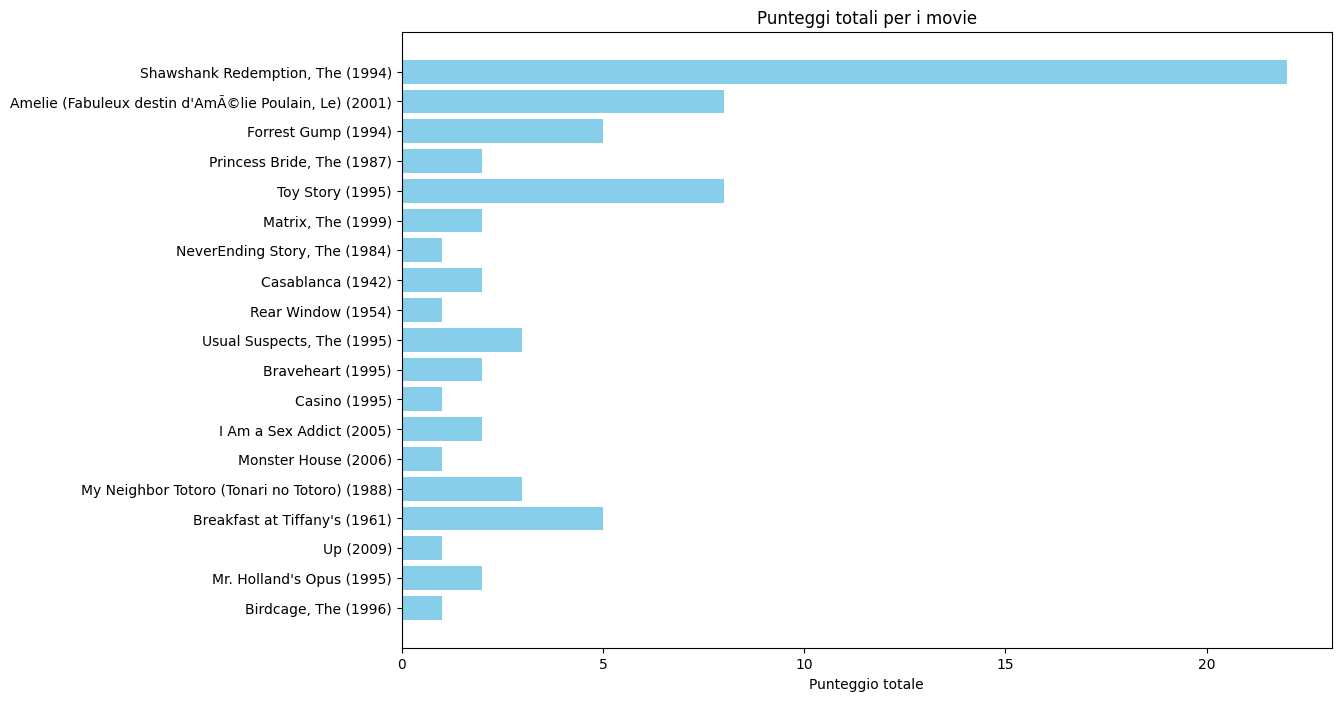

In [ ]:
# Creare un grafico a barre
nomi = [info['nome'] for info in punteggi_totali.values()]
scores = [info['punteggio'] for info in punteggi_totali.values()]

plt.figure(figsize=(12, 8))
plt.barh(nomi, scores, color='skyblue')
plt.xlabel('Punteggio totale')
plt.title('Punteggi totali per i movie')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere il punteggio più alto in alto
plt.show()
